In [28]:
# Python
import itertools
from prophet.diagnostics import cross_validation, performance_metrics
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from prophet import Prophet
import os
os.listdir()
path = open('document.txt', 'r').read().strip()

In [29]:
files = os.listdir(path)
files.sort()
print(files)
print(path + files[0])
test_data_street = files[-1]
files = files[:-1]
print(files)
print(test_data_street)


['2015_street.feather', '2016_street.feather', '2017_street.feather', '2018_street.feather', '2019_street.feather', '2020_street.feather', '2021_street.feather']
C:/Users/Arcane/Documents/Data Challenge 2/2015_street.feather
['2015_street.feather', '2016_street.feather', '2017_street.feather', '2018_street.feather', '2019_street.feather', '2020_street.feather']
2021_street.feather


## Notes Police forces
apparently 'Greater Manchester Police' force was removed from 2020 to 2021 <br><br>
'Police Service of Northern Ireland' is included from 2011 onwards

## idea
instead of only count of crimes we can implement a weighted count where more severe crimes have more effect on the total count

In [30]:
def DistrictCrimeData(district, allYears, crime):
    df_district = pd.DataFrame([])
    if allYears:
        for i in files:
            df_new = pd.read_feather(f"{path}/{i}")
            df_new = df_new[['Month', 'Falls within', 'Crime type']]
            df_new = df_new[df_new['Falls within']==district]
            if len(crime) != 0:
                df_new = df_new[df_new['Crime type'].isin(crime)]
            df_district = pd.concat([df_district, df_new], ignore_index=True)
            
    #only last year's data for testing
    else:
        df_district = pd.read_feather(f"{path}/{test_data_street}")
        df_district = df_district[['Month', 'Falls within', 'Crime type']]
        df_district = df_district[df_district['Falls within']==district]
        if len(crime) != 0:
            df_district = df_district[df_district['Crime type'].isin(crime)]

    return df_district

df_data = DistrictCrimeData(district='South Wales Police', allYears=True, crime=['Violence and sexual offences'])
df_test_data = DistrictCrimeData(district='South Wales Police', allYears=False, crime=['Violence and sexual offences'])


In [31]:
df_data['Month'].value_counts()


2019-07    3906
2020-08    3873
2018-07    3801
2019-10    3790
2019-06    3708
           ... 
2015-05    2147
2015-03    1985
2015-01    1892
2015-04    1839
2015-02    1747
Name: Month, Length: 72, dtype: int64

In [32]:

def Count_by_district(district):
    df_data = pd.DataFrame([])
    for i in files:
        if 'df_data' not in globals():
            df_data = pd.read_feather(f"{path}/{i}")
            df_data = df_data[['Month', 'Falls within']]
            df_data = df_data[df_data['Falls within']==district]
        else:
            df_new = pd.read_feather(f"{path}/{i}")
            df_new = df_new[['Month', 'Falls within']]
            df_new = df_new[df_new['Falls within']==district]
            df_data = pd.concat([df_data, df_new], ignore_index=True)

    return df_data

df_district_count = Count_by_district(district='South Wales Police')
df_district_count.head(5)





,Month,Falls within
0,2015-12,South Wales Police
1,2015-12,South Wales Police
2,2015-12,South Wales Police
3,2015-12,South Wales Police
4,2015-12,South Wales Police


In [33]:
df_test_data.sort_values(by=['Month'])


,Month,Falls within,Crime type
327611,2021-01,South Wales Police,Violence and sexual offences
336057,2021-01,South Wales Police,Violence and sexual offences
336058,2021-01,South Wales Police,Violence and sexual offences
336070,2021-01,South Wales Police,Violence and sexual offences
336071,2021-01,South Wales Police,Violence and sexual offences
...,...,...,...
4850294,2021-10,South Wales Police,Violence and sexual offences
4850295,2021-10,South Wales Police,Violence and sexual offences
4850296,2021-10,South Wales Police,Violence and sexual offences
4850236,2021-10,South Wales Police,Violence and sexual offences


In [34]:
#district = df_data[df_data['Falls within']=='South Wales Police']
#del df_data
district = df_data.copy()
predict = {}

district = district.sort_values(by=['Month'])
months = district['Month'].unique()
for i in months:
    predict[i] = len(district[district['Month']==i])
predict = pd.DataFrame({'ds': list(predict.keys()), 'y': list(predict.values())})
predict['ds'] = pd.to_datetime(predict['ds'])

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
C:\Users\Arcane\Anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
C:\Users\Arcane\Anaconda3\lib\site-packages\matplotlib\axes\_base.py:278: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]


Text(0.5, 33.0, 'Years')

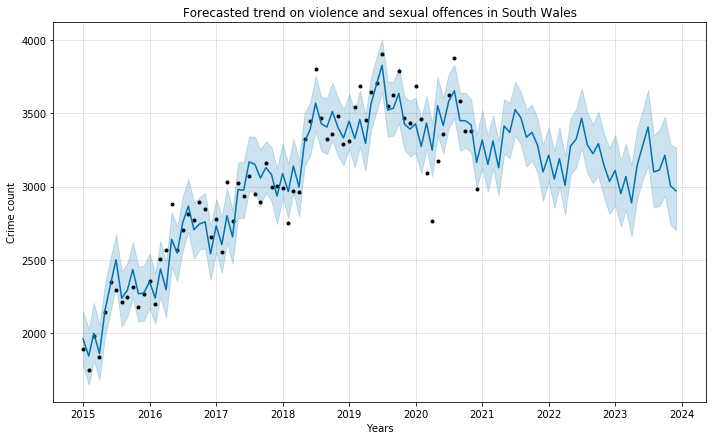

In [35]:
m = Prophet(seasonality_mode='additive').fit(predict)
future = m.make_future_dataframe(periods=36, freq='MS')
fcst = m.predict(future)
fig = m.plot(fcst)
ax = fig.gca()
ax.set_title('Forecasted trend on violence and sexual offences in South Wales')
ax.set_ylabel('Crime count')
ax.set_xlabel('Years')

C:\Users\Arcane\Anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
C:\Users\Arcane\Anaconda3\lib\site-packages\matplotlib\axes\_base.py:278: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]


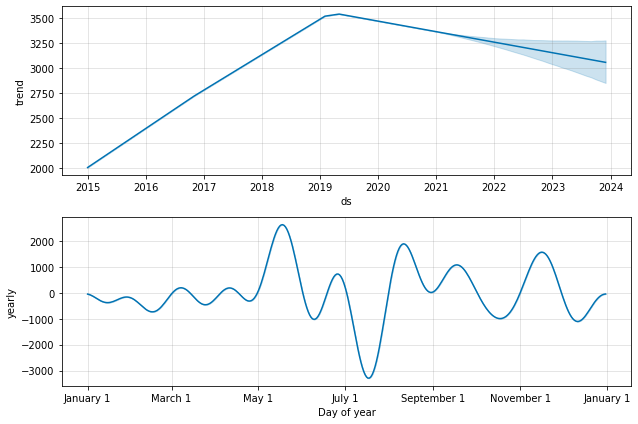

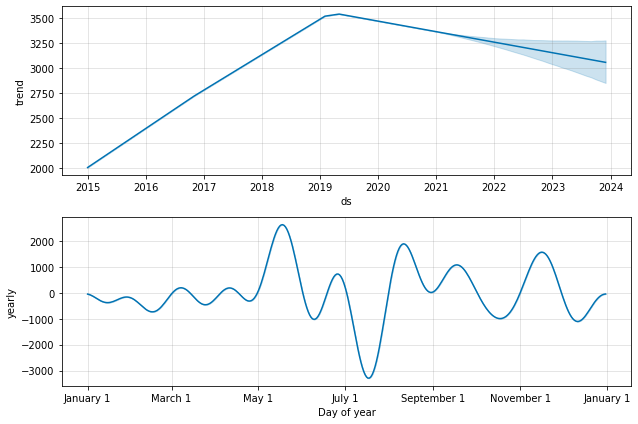

In [36]:
m.plot_components(fcst)

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
C:\Users\Arcane\Anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
C:\Users\Arcane\Anaconda3\lib\site-packages\matplotlib\axes\_base.py:278: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]


Text(0.5, 1, 'Prediction of South Wales increase in violence and sexual offences')

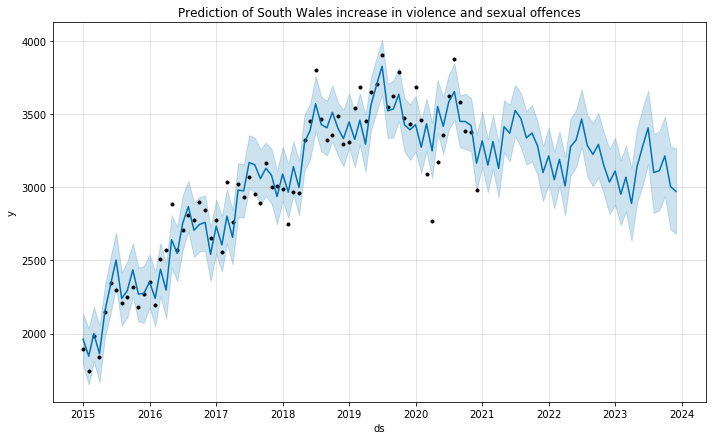

In [37]:
m = Prophet(seasonality_mode='additive').fit(predict)
future = m.make_future_dataframe(periods=36, freq='MS')
fcst = m.predict(future)
fig = m.plot(fcst)
ax = fig.gca()
ax.set_title("Prediction of South Wales increase in violence and sexual offences")

### Cross validation


In [38]:
cutoffs = pd.date_range(start='2018-01-01', end='2019-01-01', freq='2MS')
print(cutoffs)
df_cv = cross_validation(model=m, horizon='93 days', cutoffs=cutoffs)

DatetimeIndex(['2018-01-01', '2018-03-01', '2018-05-01', '2018-07-01',
               '2018-09-01', '2018-11-01', '2019-01-01'],
              dtype='datetime64[ns]', freq='2MS')


100%|██████████| 7/7 [00:13<00:00,  1.92s/it]


In [39]:
df_cv

,ds,yhat,yhat_lower,yhat_upper,y,cutoff
0,2018-02-01,2805.876359,2752.106170,2863.549185,2751,2018-01-01
1,2018-03-01,3157.845756,3103.551977,3208.538460,2969,2018-01-01
2,2018-04-01,2985.064098,2929.806734,3041.147386,2960,2018-01-01
3,2018-04-01,2939.946092,2880.580333,2999.594672,2960,2018-03-01
4,2018-05-01,3211.322223,3150.594429,3271.893308,3322,2018-03-01
5,2018-06-01,3235.369943,3176.957087,3296.448660,3450,2018-03-01
6,2018-06-01,3262.371975,3200.312554,3323.323251,3450,2018-05-01
7,2018-07-01,3276.423097,3214.067547,3335.518327,3801,2018-05-01
8,2018-08-01,3191.796513,3131.197066,3253.046910,3464,2018-05-01
9,2018-08-01,3307.155990,3203.885364,3403.071326,3464,2018-07-01


In [40]:
from prophet.diagnostics import performance_metrics
df_p = performance_metrics(df_cv)
print(df_p)
df_p['rmse'].mean()

  horizon           mse        rmse         mae      mape     mdape     smape  \
0 30 days   9367.400437   96.785332   93.982656  0.028194  0.028194  0.027781   
1 31 days  34157.972722  184.818756  149.476793  0.043797  0.045278  0.045175   
2 59 days  46464.719178  215.556766  214.075206  0.064255  0.064255  0.064364   
3 61 days  79784.409353  282.461341  221.410481  0.061218  0.036772  0.063978   
4 62 days  40117.380122  200.293235  121.315977  0.033804  0.023088  0.035194   
5 90 days  15036.175454  122.622084   98.328526  0.029066  0.029066  0.029681   
6 91 days  10872.563766  104.271587   90.118360  0.026974  0.037273  0.027128   
7 92 days  53171.922114  230.590377  212.256618  0.061012  0.070396  0.063187   

   coverage  
0      0.50  
1      0.20  
2      0.00  
3      0.00  
4      0.50  
5      0.50  
6      0.75  
7      0.25  


179.6749347683526

C:\Users\Arcane\Anaconda3\lib\site-packages\prophet\plot.py:539: FutureWarning: casting timedelta64[ns] values to int64 with .astype(...) is deprecated and will raise in a future version. Use .view(...) instead.
  x_plt = df_none['horizon'].astype('timedelta64[ns]').astype(np.int64) / float(dt_conversions[i])
C:\Users\Arcane\Anaconda3\lib\site-packages\prophet\plot.py:540: FutureWarning: casting timedelta64[ns] values to int64 with .astype(...) is deprecated and will raise in a future version. Use .view(...) instead.
  x_plt_h = df_h['horizon'].astype('timedelta64[ns]').astype(np.int64) / float(dt_conversions[i])
C:\Users\Arcane\Anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
C:\Users\Arcane\Anaconda3\lib\site-packages\matplotlib\axes\_base.py:276: FutureWarning: Support for mult

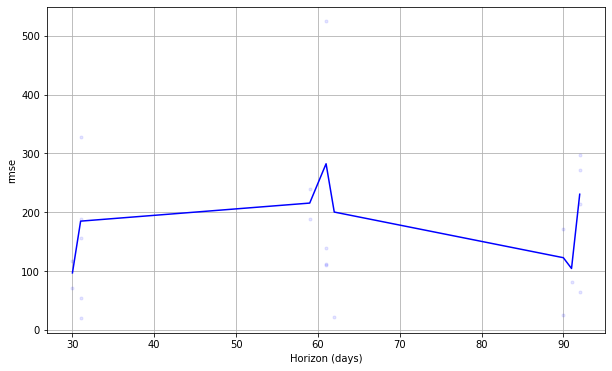

In [41]:
from prophet.plot import plot_cross_validation_metric 
fig = plot_cross_validation_metric(df_cv, metric='rmse')


In [42]:
cutoffs = pd.date_range(start='2018-01-01', end='2019-01-01', freq='2MS')
param_grid = {  
    'changepoint_prior_scale': [0.001, 0.01, 0.1, 0.5],
    'seasonality_prior_scale': [0.01, 0.1, 1.0, 10.0],
}

# Generate all combinations of parameters
all_params = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]
rmses = []
for params in all_params:
    m = Prophet(**params).fit(predict)  # Fit model with given params
    df_cv = cross_validation(m, cutoffs=cutoffs, horizon='62 days', parallel="processes")
    df_p = performance_metrics(df_cv, rolling_window=1)
    rmses.append(df_p['rmse'].values[0])

# Find the best parameters
tuning_results = pd.DataFrame(all_params)
tuning_results['rmse'] = rmses
print(tuning_results)

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x000001EE027F97B8>
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x000001EE0273D358>
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x000001EE01FFCCF8>
INFO:prophet:Disabling weekly seasonality. 

    changepoint_prior_scale  seasonality_prior_scale        rmse
0                     0.001                     0.01  195.185927
1                     0.001                     0.10  194.570993
2                     0.001                     1.00  187.347064
3                     0.001                    10.00  184.474727
4                     0.010                     0.01  206.414790
5                     0.010                     0.10  192.699391
6                     0.010                     1.00  184.511773
7                     0.010                    10.00  184.190150
8                     0.100                     0.01  226.482822
9                     0.100                     0.10  213.158686
10                    0.100                     1.00  211.909082
11                    0.100                    10.00  211.343737
12                    0.500                     0.01  248.989782
13                    0.500                     0.10  319.209247
14                    0.5

In [43]:
best_params = all_params[np.argmin(rmses)]
print(best_params)

{'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 10.0}


### Other data aggregation


In [44]:
df_data0 = pd.read_feather(f"{path}/{files[0]}")
df_data1 = pd.read_feather(f"{path}/{files[1]}")
df_data2 = pd.read_feather(f"{path}/{files[2]}")
df_data3 = pd.read_feather(f"{path}/{files[3]}")
df_data4 = pd.read_feather(f"{path}/{files[4]}")
df_data5 = pd.read_feather(f"{path}/{files[5]}")

In [45]:

crimes = df_data0['Crime type'].value_counts().keys()
crimeCount0 = df_data0['Crime type'].value_counts()
crimeCount1 = df_data1['Crime type'].value_counts()
crimeCount2 = df_data2['Crime type'].value_counts()
crimeCount3 = df_data3['Crime type'].value_counts()
crimeCount4 = df_data4['Crime type'].value_counts()
crimeCount5 = df_data5['Crime type'].value_counts()
dic0 = dict(zip(crimes, crimeCount0))
dic1 = dict(zip(crimes, crimeCount1))
dic2 = dict(zip(crimes, crimeCount2))
dic3 = dict(zip(crimes, crimeCount3))
dic4 = dict(zip(crimes, crimeCount4))
dic5 = dict(zip(crimes, crimeCount5))
df_crime_distribution = pd.DataFrame(columns=crimes)
df_crime_distribution = df_crime_distribution.append(dic0, ignore_index=True)
df_crime_distribution = df_crime_distribution.append(dic1, ignore_index=True)
df_crime_distribution = df_crime_distribution.append(dic2, ignore_index=True)
df_crime_distribution = df_crime_distribution.append(dic3, ignore_index=True)
df_crime_distribution = df_crime_distribution.append(dic4, ignore_index=True)
df_crime_distribution = df_crime_distribution.append(dic5, ignore_index=True)
df_crime_distribution

,Anti-social behaviour,Violence and sexual offences,Criminal damage and arson,Other theft,Burglary,Vehicle crime,Shoplifting,Public order,Drugs,Bicycle theft,Theft from the person,Other crime,Robbery,Possession of weapons
0,1875251,1049161,549145,505583,410576,368568,339123,193944,151248,88163,83092,63224,51628,25162
1,1852894,1233265,571144,497262,409399,394556,362286,254027,137670,86726,83586,74172,56130,31229
2,1712771,1512942,603824,544405,458419,445689,389625,367198,136784,102983,100667,93174,74329,40137
3,1789313,1436624,577112,552890,467788,435702,430086,379399,148270,103570,101242,96848,82621,45848
4,1883205,1311848,549655,520104,447553,436909,384606,359312,175808,110894,103584,88126,87075,46923
5,1869066,1774618,484456,445214,366362,347893,282623,248429,198153,104403,77375,63196,62345,42869


In [46]:
df_crime_distribution1 = pd.DataFrame(columns=crimes)
df_crime_distribution1 = df_crime_distribution1.append(dic0, ignore_index=True)

In [47]:
#df_crime_distribution.to_feather(f"C:/Users/Arcane/Documents/Data Challenge 2/extra")

Text(0.5, 1.0, 'Amount of crime for each crime type per year')

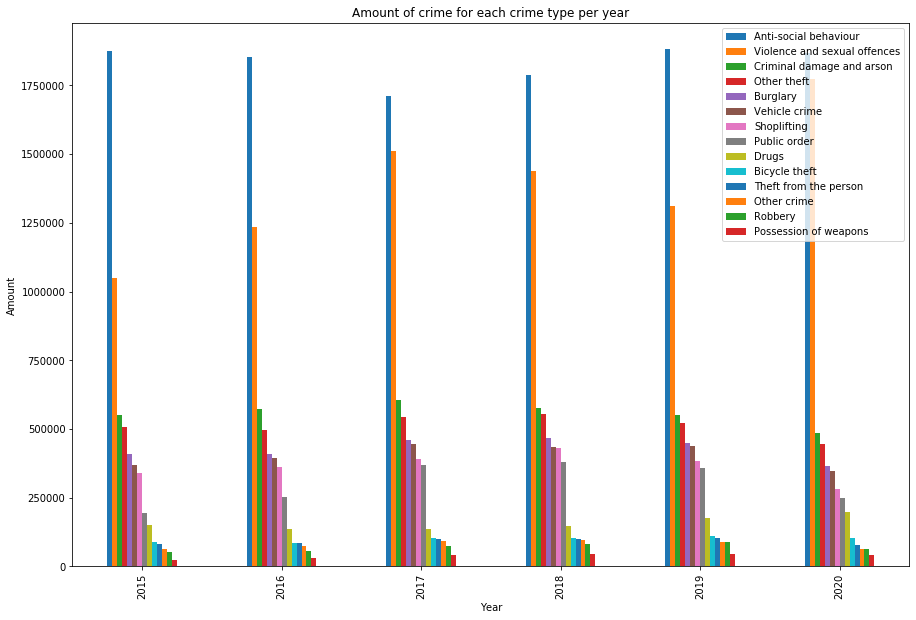

In [48]:
ax = df_crime_distribution.plot.bar(figsize=(15,10))
ax.set_xticklabels([2015, 2016, 2017, 2018, 2019, 2020])
ax.set_xlabel('Year')
ax.set_ylabel('Amount')
ax.set_title('Amount of crime for each crime type per year')


   Total crimes
0       5753868
1       6044346
2       6582947
3       6647313
4       6505602
5       6367002


([<matplotlib.axis.XTick at 0x1ee02805cf8>,
 <a list of 6 Text xticklabel objects>)

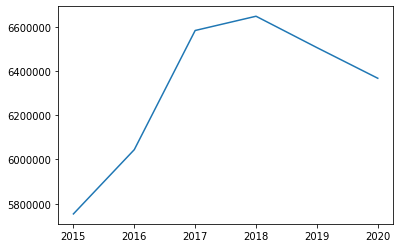

In [49]:
sum0 = sum(crimeCount0)
sum1 = sum(crimeCount1)
sum2 = sum(crimeCount2)
sum3 = sum(crimeCount3)
sum4 = sum(crimeCount4)
sum5 = sum(crimeCount5)

df_total_crimes = pd.DataFrame(data = {'Total crimes' : [sum0,sum1,sum2,sum3,sum4,sum5]})
print(df_total_crimes)
plt.plot(df_total_crimes)
plt.rcParams["figure.figsize"] = (10,5)
plt.xticks([0, 1, 2, 3, 4, 5], ['2015', '2016', '2017', '2018', '2019', '2020'])

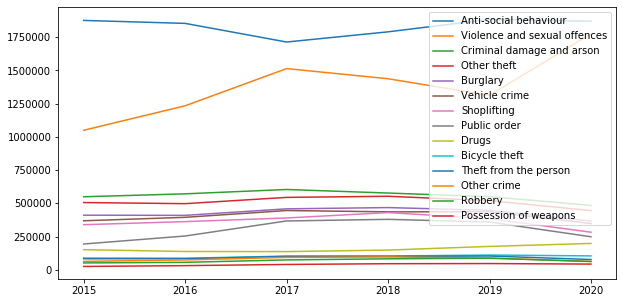

In [50]:
plt.plot(df_crime_distribution)
plt.rcParams["figure.figsize"] = (15,10)
plt.xticks([0, 1, 2, 3, 4, 5], ['2015', '2016', '2017', '2018', '2019', '2020'])
plt.legend(crimes, loc='upper right')